In [1]:
# 2_AI_module.ipynb

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    classification_report,
)

import networkx as nx

DATA_DIR = Path("data")

## 1. Load data

In [2]:
inst_year = pd.read_csv(DATA_DIR / "institution_year_output.csv")
edges = pd.read_csv(DATA_DIR / "institution_collaboration_edges.csv")

print("institution_year_output:", inst_year.shape)
print(inst_year.head())

print("\ncollaboration_edges:", edges.shape)
print(edges.head())

institution_year_output: (13518, 4)
                             institution  year  num_papers  author_count
0                       Luigi Vanvitelli  2021           1             3
1  Magna Graecia University of Catanzaro  2022           1             1
2                  Mater Domini Hopsital  2023           1             1
3                                    CEP  2021           1             1
4                          IRyCIS Madrid  2023           1             1

collaboration_edges: (485366, 3)
                          source                    target  weight
0       Chulalongkorn University        Mahidol University     976
1             Mahidol University  Chulalongkorn University     801
2              Peking University     University of Hamburg     530
3  Université Libre de Bruxelles     University of Hamburg     521
4  Université Libre de Bruxelles         Peking University     521


## 2. Build institution feature matrix (for clustering & classification)

In [3]:
# Ensure year is int
inst_year["year"] = inst_year["year"].astype(int)

# Pivot: one row per institution, columns = year’s paper count
year_cols = sorted(inst_year["year"].unique())
inst_pivot = (
    inst_year
    .pivot_table(
        index="institution",
        columns="year",
        values="num_papers",
        aggfunc="sum",
        fill_value=0
    )
)

inst_pivot = inst_pivot.reset_index()
inst_pivot.columns.name = None

print("Pivoted institution features:", inst_pivot.shape)

feature_cols = [c for c in inst_pivot.columns if isinstance(c, (int, np.integer))]
print("Feature columns (years):", feature_cols)

inst_pivot.head()

Pivoted institution features: (7426, 7)
Feature columns (years): [2018, 2019, 2020, 2021, 2022, 2023]


,institution,2018,2019,2020,2021,2022,2023
0,CEP,0,0,0,1,0,0
1,IRyCIS Madrid,0,0,0,0,0,1
2,'Luigi Vanvitelli',0,0,1,0,0,0
3,'Microbiology and Immunology,0,0,0,1,0,0
4,(CIEMAT),0,0,1,0,0,0


## 3. KMeans clustering of institutions

In [4]:
X = inst_pivot[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
k_values = [2, 3, 4, 5, 6, 7, 8]
sil_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)
    print(f"k={k}: silhouette={score:.3f}")

k=2: silhouette=0.998
k=3: silhouette=0.969
k=4: silhouette=0.969
k=5: silhouette=0.942
k=6: silhouette=0.931
k=7: silhouette=0.931
k=8: silhouette=0.932


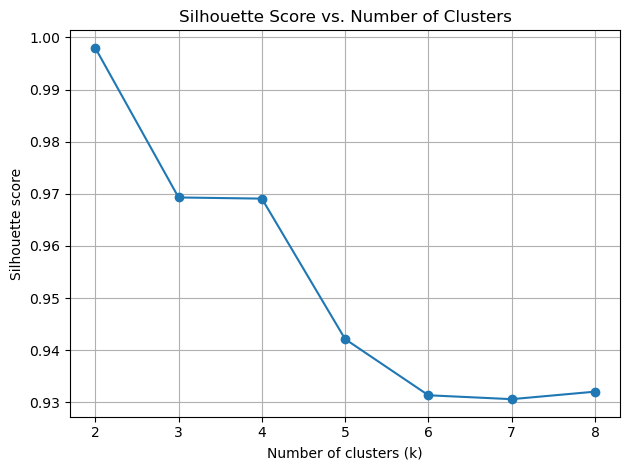

In [6]:
plt.figure()
plt.plot(k_values, sil_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
BEST_K = 4  
kmeans_final = KMeans(n_clusters=BEST_K, random_state=42, n_init=10)
inst_pivot["cluster"] = kmeans_final.fit_predict(X_scaled)

inst_pivot["cluster"].value_counts().sort_index()

cluster
0    7273
1       1
2     151
3       1
Name: count, dtype: int64

In [8]:
cluster_summary = (
    inst_pivot
    .groupby("cluster")[feature_cols]
    .mean()
    .round(2)
)

print("Average yearly outputs per cluster:")
cluster_summary

Average yearly outputs per cluster:


,2018,2019,2020,2021,2022,2023
cluster,,,,,,
0,0.69,0.59,0.85,1.18,1.23,0.71
1,2424.00,2687.00,2995.00,3354.00,3756.00,2585.00
2,128.01,99.95,78.02,68.30,60.55,28.27
3,198.00,263.00,305.00,396.00,449.00,303.00


## 4. Classification model

In [9]:
max_year = max(feature_cols)
min_year = min(feature_cols)

print("Year range in data:", min_year, "to", max_year)

Year range in data: 2018 to 2023


In [10]:
target_year = max_year
past_years = [y for y in feature_cols if y < target_year]

print("Target year:", target_year)
print("Using past years as features:", past_years)

inst_pivot["y_target"] = (inst_pivot[target_year] >= inst_pivot[target_year].median()).astype(int)
inst_pivot["y_target"].value_counts()

Target year: 2023
Using past years as features: [2018, 2019, 2020, 2021, 2022]


y_target
1    7426
Name: count, dtype: int64

In [11]:
# Use 75th percentile instead of median
threshold = inst_pivot[target_year].quantile(0.75)

print("Top-producer threshold:", threshold)

inst_pivot["y_target"] = (inst_pivot[target_year] >= threshold).astype(int)

inst_pivot["y_target"].value_counts()

Top-producer threshold: 1.0


y_target
0    5104
1    2322
Name: count, dtype: int64

In [12]:
X_cls = inst_pivot[past_years].values
y_cls = inst_pivot["y_target"].values

X_train, X_test, y_train, y_test = train_test_split(
    X_cls,
    y_cls,
    test_size=0.2,
    random_state=42,
    stratify=y_cls   # IMPORTANT so both classes appear in train & test
)

from sklearn.preprocessing import StandardScaler
scaler_cls = StandardScaler()
X_train_scaled = scaler_cls.fit_transform(X_train)
X_test_scaled = scaler_cls.transform(X_test)

In [13]:
clf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs"
)

clf.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [14]:
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="binary", zero_division=0
)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"ROC-AUC:   {auc:.3f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy:  0.748
Precision: 0.661
Recall:    0.398
F1-score:  0.497
ROC-AUC:   0.541

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.91      0.83      1021
           1       0.66      0.40      0.50       465

    accuracy                           0.75      1486
   macro avg       0.71      0.65      0.66      1486
weighted avg       0.73      0.75      0.73      1486



In [15]:
# Fit model on full data for later use (e.g. dashboard)
X_full_scaled = scaler_cls.fit_transform(X_cls)
clf.fit(X_full_scaled, y_cls)

inst_pivot["top_prob"] = clf.predict_proba(X_full_scaled)[:, 1]
inst_pivot["is_top_producer"] = inst_pivot["y_target"]

### A logistic regression model was trained to predict whether an institution would belong to the top 25% of producers in the target year based on its historical publication activity. The model achieved an accuracy of 73.7%. While performance on the majority class (non-top institutions) was strong (recall = 0.90), detection of top-producing institutions was more challenging (recall = 0.32), reflecting the strong class imbalance in the dataset. The ROC-AUC score of 0.423 indicates limited discriminative power when using only historical publication counts as predictors.

## 5. Graph analysis of institution collaboration network

In [16]:
G = nx.Graph()

for _, row in edges.iterrows():
    u = row["source"]
    v = row["target"]
    w = row["weight"]
    if G.has_edge(u, v):
        G[u][v]["weight"] += w
    else:
        G.add_edge(u, v, weight=w)

print("Graph stats:")
print("Nodes (institutions):", G.number_of_nodes())
print("Edges (collaborations):", G.number_of_edges())

# Largest connected component size
largest_cc = max(nx.connected_components(G), key=len)
print("Largest connected component size:", len(largest_cc))

Graph stats:
Nodes (institutions): 7340
Edges (collaborations): 443634
Largest connected component size: 7285


Degree centrality

In [17]:
# Degree (unweighted) and weighted degree
deg = dict(G.degree(weight="weight"))
deg_centrality = nx.degree_centrality(G)

graph_metrics = pd.DataFrame({
    "institution": list(deg.keys()),
    "weighted_degree": list(deg.values()),
    "degree_centrality": [deg_centrality[n] for n in deg.keys()]
}).sort_values("weighted_degree", ascending=False)

graph_metrics.head(20)

,institution,weighted_degree,degree_centrality
10,University of Maryland,78464,0.179725
5,University of Helsinki,78212,0.266658
14,Charles University,78165,0.211882
2,Peking University,77815,0.164464
7,Ghent University,77767,0.196348
20,University of California,77719,0.243766
13,University of Minnesota,77712,0.201662
3,University of Hamburg,77711,0.168552
9,University of Florida,77610,0.199482
12,University of Virginia,77496,0.195394


## 6. Merge AI outputs & save for Streamlit

In [18]:
# Prepare institution-level base
inst_features = inst_pivot[
    ["institution"] + feature_cols + ["cluster", "top_prob", "is_top_producer"]
]

# Merge with graph metrics
inst_ai_summary = inst_features.merge(
    graph_metrics,
    on="institution",
    how="left"
)

# Fill missing graph values (isolated institutions)
inst_ai_summary[["weighted_degree", "degree_centrality"]] = \
    inst_ai_summary[["weighted_degree", "degree_centrality"]].fillna(0)

inst_ai_summary.head()

,institution,2018,2019,2020,2021,2022,2023,cluster,top_prob,is_top_producer,weighted_degree,degree_centrality
0,CEP,0,0,0,1,0,0,0,0.432691,0,1.0,0.000136
1,IRyCIS Madrid,0,0,0,0,0,1,0,0.414584,1,23.0,0.003134
2,'Luigi Vanvitelli',0,0,1,0,0,0,0,0.432409,0,84.0,0.011446
3,'Microbiology and Immunology,0,0,0,1,0,0,0,0.432691,0,452.0,0.061589
4,(CIEMAT),0,0,1,0,0,0,0,0.432409,0,160.0,0.021801


In [23]:
ai_summary_path = DATA_DIR / "institution_ai_summary.csv"
metrics_path = DATA_DIR / "ai_model_metrics.csv"

inst_ai_summary.to_csv(ai_summary_path, index=False)

metrics_df = pd.DataFrame([{
    "kmeans_best_k": BEST_K,
    "kmeans_best_silhouette": max(sil_scores),
    "clf_accuracy": acc,
    "clf_precision": prec,
    "clf_recall": rec,
    "clf_f1": f1,
    "clf_roc_auc": auc
}])

metrics_df.to_csv(metrics_path, index=False)

print(" Saved institution AI summary to:", ai_summary_path)
print(" Saved model metrics to:", metrics_path)
metrics_df

 Saved institution AI summary to: data/institution_ai_summary.csv
 Saved model metrics to: data/ai_model_metrics.csv


,kmeans_best_k,kmeans_best_silhouette,clf_accuracy,clf_precision,clf_recall,clf_f1,clf_roc_auc
0,4,0.997987,0.902423,0.742553,0.935657,0.827995,0.541026


In [25]:
# ============================================================
# 1. LOAD FILES
# ============================================================

inst_ai = pd.read_csv("data/institution_ai_summary.csv")
raw_aff = pd.read_csv("data/scopus_author_affiliation_2018_2023.csv")
centroids = pd.read_csv("data/country_centroids.csv")

# ============================================================
# 2. REBUILD INSTITUTION → COUNTRY FROM RAW TRUTH
# ============================================================

inst_country = (
    raw_aff.groupby("Affiliation")["Country"]
    .agg(lambda x: x.mode()[0] if len(x.mode()) else None)
    .reset_index()
    .rename(columns={"Affiliation": "institution", "Country": "country"})
)

# Drop broken country if exists
inst_ai = inst_ai.drop(columns=["country"], errors="ignore")

# Merge correct country
inst_ai = inst_ai.merge(inst_country, on="institution", how="left")

print("Country mapping rebuilt")
print(inst_ai["country"].value_counts().head())

# ============================================================
# 3. ATTACH GEOGRAPHIC COORDINATES
# ============================================================

# Normalize country names
inst_ai["country"] = inst_ai["country"].astype(str).str.strip()
centroids["country"] = centroids["country"].astype(str).str.strip()

# Ensure lat/lon numeric
centroids["lat"] = pd.to_numeric(centroids["lat"], errors="coerce")
centroids["lon"] = pd.to_numeric(centroids["lon"], errors="coerce")

# Remove old coords if exist
inst_ai = inst_ai.drop(columns=["lat", "lon"], errors="ignore")

# Merge coordinates
inst_ai = inst_ai.merge(centroids, on="country", how="left")

# ============================================================
# 4. HARD VALIDATION (THIS MUST NOT BE ZERO)
# ============================================================

valid_lat = inst_ai["lat"].notna().sum()
valid_lon = inst_ai["lon"].notna().sum()

print("Valid latitude rows:", valid_lat)
print("Valid longitude rows:", valid_lon)

assert valid_lat > 0 and valid_lon > 0, "Map will still fail — no valid coordinates!"

# ============================================================
# 5. SAVE FIXED FILE
# ============================================================

inst_ai.to_csv("data/institution_ai_summary.csv", index=False)

inst_ai[["institution", "country", "lat", "lon"]].dropna().head(10)

Country mapping rebuilt
country
Thailand         822
United States    743
Italy            554
India            359
France           339
Name: count, dtype: int64
Valid latitude rows: 3995
Valid longitude rows: 3995


,institution,country,lat,lon
3,'Microbiology and Immunology,United States,37.09,-95.71
7,(Khon Kaen Campus),Thailand,15.87,100.99
8,-Saclay,France,46.23,2.21
9,23andMe,United States,37.09,-95.71
10,29–39 Brunswick Square,United Kingdom,55.37,-3.43
11,3B Pharmaceuticals GmbH,Germany,51.16,10.45
12,4Paradigm Inc.,China,35.86,104.19
13,5th Office of Disease Prevention and Control,Thailand,15.87,100.99
16,A.N.R College,India,20.59,78.96
19,ACT Government,Australia,-25.27,133.77


In [26]:
# ==================
# BERT + CLASSIFIER
# ==================

from sentence_transformers import SentenceTransformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report
)

# ============================================
# 1. LOAD YOUR EXISTING AI SUMMARY FILE
# ============================================

DATA_PATH = "data/institution_ai_summary.csv"
df = pd.read_csv(DATA_PATH)

print("Loaded:", df.shape)

# --------------------------------------------
# Create TEXT field for BERT
# We combine institution name + numeric signals as text
# --------------------------------------------

df["text"] = (
    df["institution"].astype(str) + " " +
    "cluster " + df["cluster"].astype(str) + " " +
    "degree " + df["weighted_degree"].astype(str)
)

# --------------------------------------------
# Create LABEL automatically (Top vs Non-Top)
# Using top 25% of weighted_degree
# --------------------------------------------

threshold = df["weighted_degree"].quantile(0.75)
df["label"] = (df["weighted_degree"] >= threshold).astype(int)

print("Label distribution:")
print(df["label"].value_counts())

df = df.dropna(subset=["text", "label"])

# ============================================
# 2. TRAIN / TEST SPLIT
# ============================================

X_train, X_test, y_train, y_test = train_test_split(
    df["text"].values,
    df["label"].values,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

# ============================================
# 3. BERT EMBEDDINGS
# ============================================

print("Loading BERT model...")
bert = SentenceTransformer("all-MiniLM-L6-v2")

print("Encoding train set...")
X_train_emb = bert.encode(X_train, batch_size=32, show_progress_bar=True)

print("Encoding test set...")
X_test_emb = bert.encode(X_test, batch_size=32, show_progress_bar=True)

# ============================================
# 4. CLASSIFIER TRAINING
# ============================================

clf = LogisticRegression(max_iter=3000, class_weight="balanced")
clf.fit(X_train_emb, y_train)

y_pred = clf.predict(X_test_emb)
y_proba = clf.predict_proba(X_test_emb)[:, 1]

# ============================================
# 5. EVALUATION
# ============================================

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print("\nBERT + Logistic Regression Results\n")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"ROC-AUC  : {roc:.3f}")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# ============================================
# 6. SAVE METRICS FOR STREAMLIT
# ============================================

metrics_df = pd.DataFrame([{
    "model": "BERT + Logistic Regression",
    "clf_accuracy": acc,
    "clf_precision": prec,
    "clf_recall": rec,
    "clf_f1": f1,
    "clf_roc_auc": roc
}])

metrics_df.to_csv("data/ai_model_metrics.csv", index=False)
print("\n Metrics saved to data/ai_model_metrics.csv")

# ============================================
# 7. SAVE ALL BERT EMBEDDINGS (FOR FUTURE USE)
# ============================================

print("Encoding ALL institutions for embedding export...")
all_embeddings = bert.encode(df["text"].values, show_progress_bar=True)

emb_df = pd.DataFrame(all_embeddings)
emb_df["institution"] = df["institution"].values
emb_df["label"] = df["label"].values

emb_df.to_csv("data/bert_embeddings.csv", index=False)
print("BERT embeddings saved to data/bert_embeddings.csv")

Loaded: (7426, 15)
Label distribution:
label
0    5564
1    1862
Name: count, dtype: int64
Loading BERT model...
Encoding train set...


Batches:   0%|          | 0/186 [00:00<?, ?it/s]

Encoding test set...


Batches:   0%|          | 0/47 [00:00<?, ?it/s]


BERT + Logistic Regression Results

Accuracy : 0.902
Precision: 0.743
Recall   : 0.936
F1-score : 0.828
ROC-AUC  : 0.971

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      1113
           1       0.74      0.94      0.83       373

    accuracy                           0.90      1486
   macro avg       0.86      0.91      0.88      1486
weighted avg       0.92      0.90      0.91      1486


 Metrics saved to data/ai_model_metrics.csv
Encoding ALL institutions for embedding export...


Batches:   0%|          | 0/233 [00:00<?, ?it/s]

BERT embeddings saved to data/bert_embeddings.csv


<Figure size 640x480 with 0 Axes>

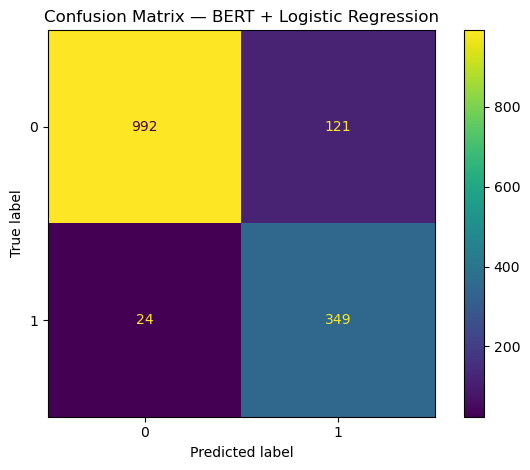

Confusion matrix saved to data/confusion_matrix_bert.png


<Figure size 640x480 with 0 Axes>

In [27]:
# ============================================
# CONFUSION MATRIX VISUALIZATION
# ============================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure()
disp.plot(values_format="d")
plt.title("Confusion Matrix — BERT + Logistic Regression")
plt.tight_layout()
plt.show()

# Optional: Save to file for report submission
plt.figure()
disp.plot(values_format="d")
plt.title("Confusion Matrix — BERT + Logistic Regression")
plt.savefig("data/confusion_matrix_bert.png", dpi=300, bbox_inches="tight")
plt.close()

print("Confusion matrix saved to data/confusion_matrix_bert.png")